In [1]:
import csv
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import astropy.units as u
from astropy.modeling.models import Sine1D
from sklearn.linear_model import LinearRegression
import pandas as pd
from astropy.modeling import models, fitting
from lightkurve.correctors import PLDCorrector
import lmfit

In [2]:
palette = sns.color_palette(palette='flare')
palette

[(0.9155979, 0.55210684, 0.42070204),
 (0.888292, 0.40830288, 0.36223756),
 (0.81942908, 0.28911553, 0.38102921),
 (0.69226314, 0.23413578, 0.42480327),
 (0.56041794, 0.19845221, 0.44207535),
 (0.42355299, 0.16934709, 0.42581586)]

In [3]:
# Define dataframes
df = pd.read_csv('query_data/comma_test_query.csv')
all_df = df[['iau_name', 'i', 'porb', 'porbe']]

# Dataframe with orbital period calculations
porb_df = all_df[all_df['porb'] != 0].reset_index()
# Dataframe without orbital period calculations
no_porb_df = all_df[all_df['porb'] == 0].reset_index()

In [4]:
# Define a sine wave function
def sine_wave(x, amplitude, frequency, phase):
    return amplitude * np.sin((2 * np.pi * frequency * x) + phase)

### Stars w/ known period

#### SDSSJ013851.54-001621.6

In [5]:
# Pull lightcurve data for that star
star_info = porb_df.iloc[2]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                            30
iau_name    SDSSJ013851.54-001621.6
i                             15.89
porb                       1.746529
porbe                           0.0
Name: 2, dtype: object 

SearchResult containing 12 data products.

 #     mission     year       author      exptime target_name distance
                                             s                 arcsec 
--- -------------- ---- ----------------- ------- ----------- --------
  0 TESS Sector 70 2023              SPOC     120   241444875      0.0
  1 TESS Sector 03 2018         TESS-SPOC    1800   241444875      0.0
  2 TESS Sector 30 2020         TESS-SPOC     600   241444875      0.0
  3 TESS Sector 42 2021         TESS-SPOC     600   241444875      0.0
  4 TESS Sector 43 2021         TESS-SPOC     600   241444875      0.0
  5 TESS Sector 30 2020               QLP     600   241444875      0.0
  6 TESS Sector 42 2021               QLP     600   241444875      0.0
  7 TESS Sector 43 2021               QLP 

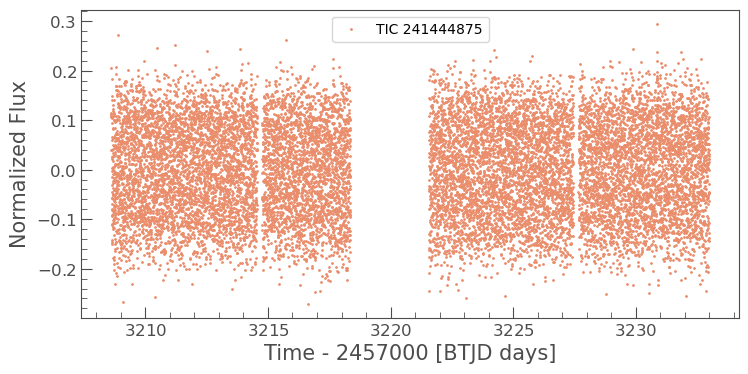

In [6]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[0])
plt.legend()
plt.show()

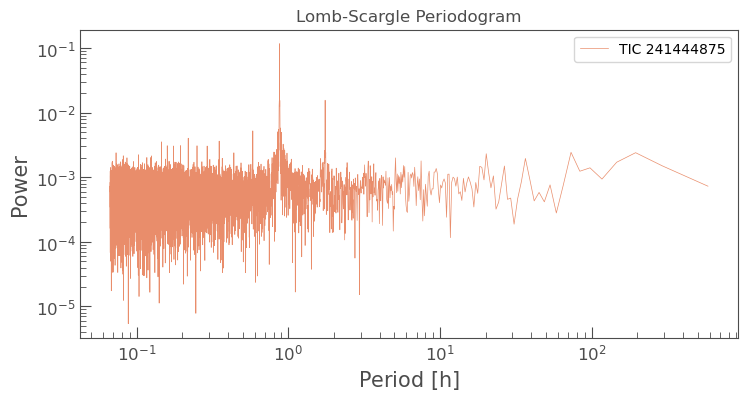

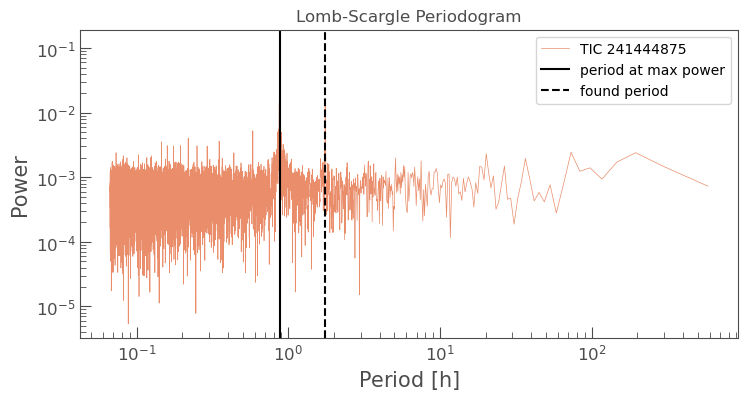

Original calculated period(h): 1.746529272 
Period at max power(h): 0.8732017722876133


In [7]:
# Make periodogram
found_period = star_info['porb']
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.axvline(x = found_period, color= 'black', ls = '--', label = 'found period')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

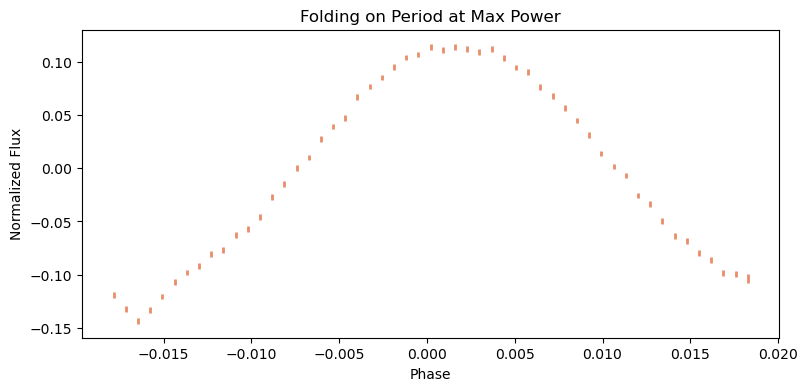

In [8]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(1*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[0], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

0.8732017722876133 d


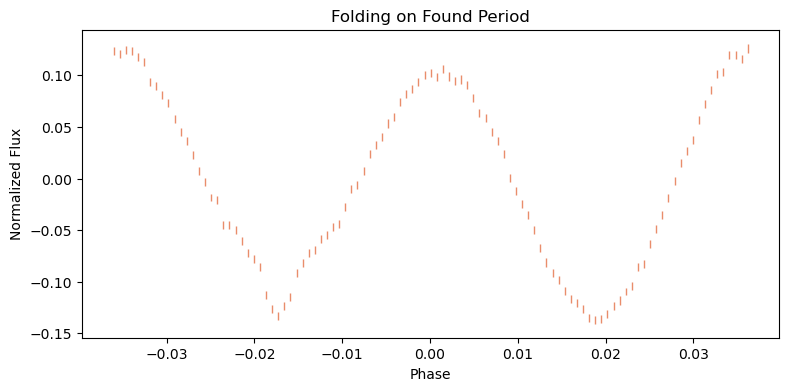

In [9]:
# Defined folded and binned lightcurve
print(star_periodogram.period_at_max_power*24)
phase_lightcurve = star_lightcurve.fold(period=(found_period/24))
binned_lightcurve = phase_lightcurve.bin(1*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[0], lw=1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Found Period')
plt.show()

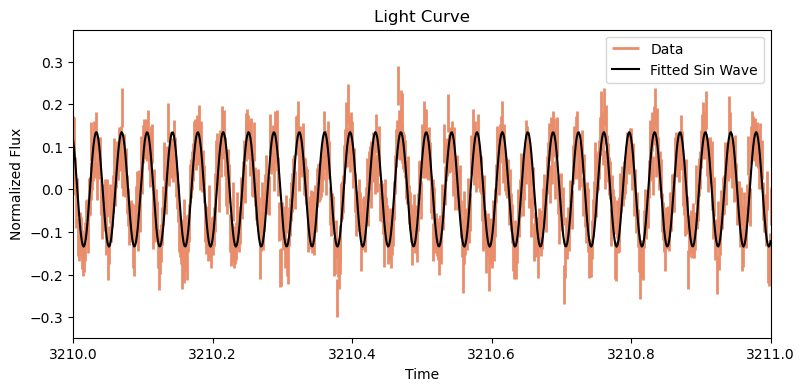

[[Model]]
    Model(sine_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 14937
    # variables        = 3
    chi-square         = 44.2434608
    reduced chi-square = 0.00296260
    Akaike info crit   = -86955.5568
    Bayesian info crit = -86932.7220
    R-squared          = 0.66655897
[[Variables]]
    amplitude: -0.13448848 +/- 0.01203748 (8.95%) (init = 0.1172641)
    frequency:  27.4844076 +/- 9.8693e-05 (0.00%) (init = 27.48506)
    phase:     -0.72908773 +/- 0.23706985 (32.52%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(frequency, phase)     = +0.9998
    C(amplitude, frequency) = -0.9986
    C(amplitude, phase)     = -0.9984


In [10]:
# Lightcurve data
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Get the current 'optimal paramteres'
amplitude = max(star_periodogram.power.value)
frequency = 1/star_periodogram.period_at_max_power.value

# Make an lmfit object and fit it
model = lmfit.Model(sine_wave)
params = model.make_params(amplitude=amplitude, frequency=frequency, phase=0.0)
result = model.fit(flux, params, x=time)

# Plot the fitted sin wave
plt.figure(figsize= (9,4))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[0], lw=2, label = 'Data')
plt.plot(time, result.best_fit, color= 'black', label = 'Fitted Sin Wave')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(3210, 3211)
plt.legend()
plt.show()

print(result.fit_report())

In [11]:
best_fit_frequency = result.params['frequency'].value
best_fit_period = 1/best_fit_frequency

print(f"Best fit period: {best_fit_period} days")
print(f"Period at max power: {star_periodogram.period_at_max_power.value} days")
print(f"Period from literature: {found_period/24} days")

Best fit period: 0.03638426609000787 days
Period at max power: 0.03638340717865055 days
Period from literature: 0.072772053 days


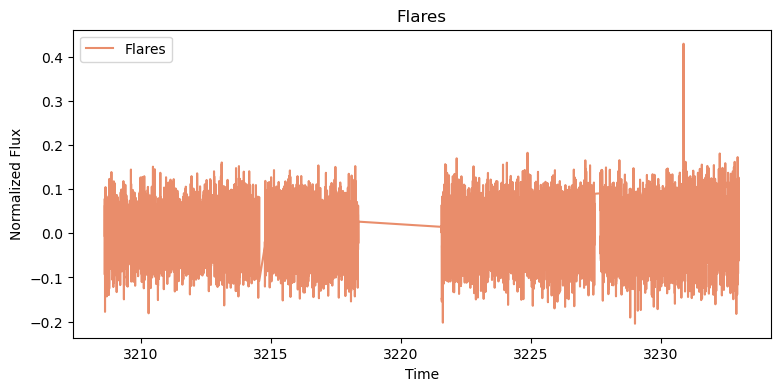

In [12]:
# Get flare data
flare_data = flux - result.best_fit

# Plot the flares
plt.figure(figsize=(9, 4))
plt.plot(time, flare_data, label='Flares', color=palette[0])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Flares')
plt.legend()
plt.show()

#### SDSSJ082145.27+455923.4

In [13]:
# Pull lightcurve data for that star
star_info = porb_df.iloc[9]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                           106
iau_name    SDSSJ082145.27+455923.4
i                           17.6232
porb                      12.218165
porbe                      0.000002
Name: 9, dtype: object 

SearchResult containing 6 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 20 2019      SPOC     120   802015620      0.0
  1 TESS Sector 47 2021      SPOC     120   802015620      0.0
  2 TESS Sector 60 2022      SPOC     120   802015620      0.0
  3 TESS Sector 20 2019 TESS-SPOC    1800   802015620      0.0
  4 TESS Sector 47 2021 TESS-SPOC     600   802015620      0.0
  5 TESS Sector 60 2022 TESS-SPOC     200   802015620      0.0


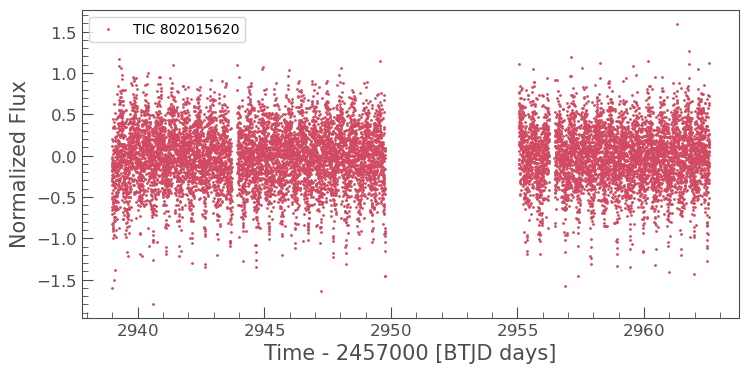

In [14]:
# Download 'best' lightcurve
star_lightcurve = star_result[2].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[2])
plt.legend()
plt.show()

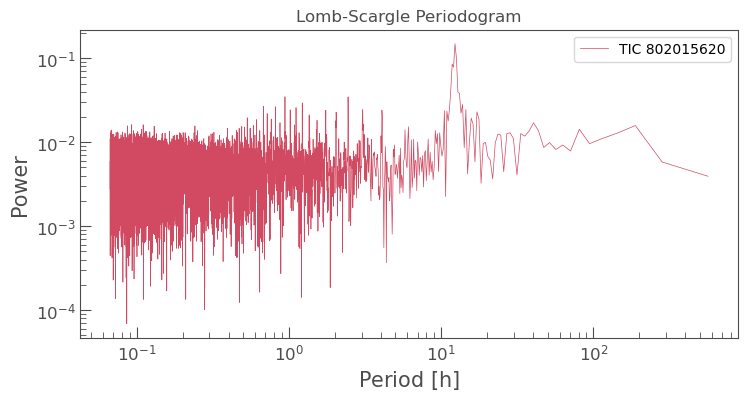

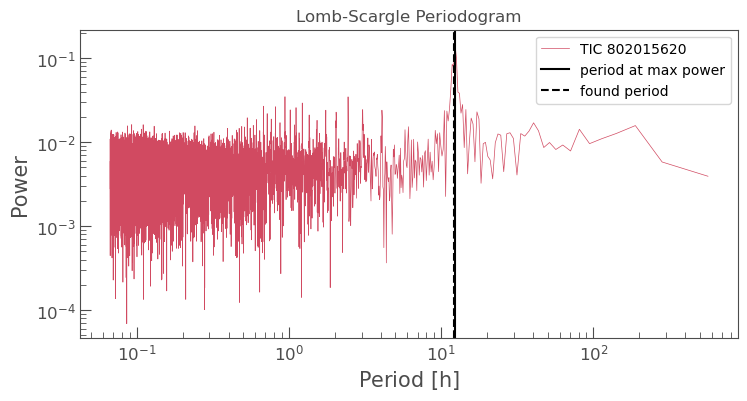

Original calculated period(h): 12.2181648 
Period at max power(h): 12.32340239295888


In [15]:
# Make periodogram
found_period = star_info['porb']
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[2], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[2], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.axvline(x = found_period, color= 'black', ls = '--', label = 'found period')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

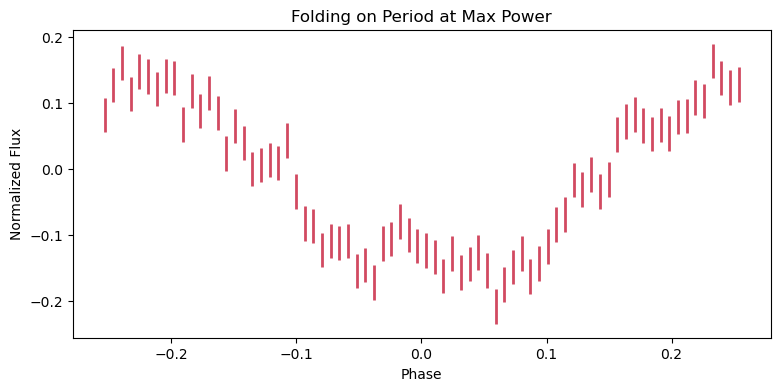

In [16]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(10*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[2], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

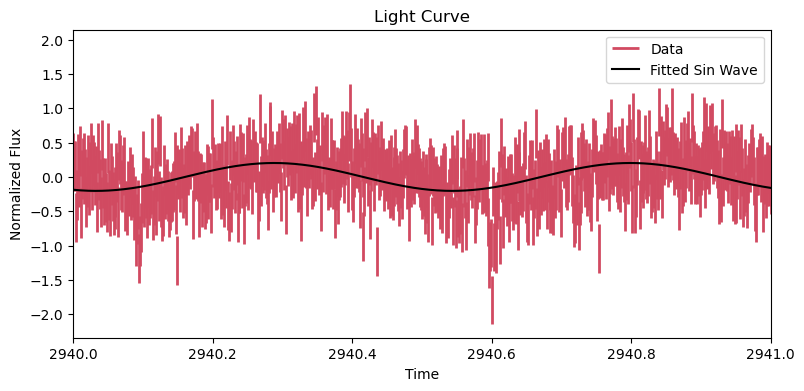

[[Model]]
    Model(sine_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 12892
    # variables        = 3
    chi-square         = 1433.11872
    reduced chi-square = 0.11118929
    Akaike info crit   = -28314.5522
    Bayesian info crit = -28292.1591
    R-squared          = 0.13655433
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  0.20324804 (init = 0.1491146)
    frequency:  1.95828526 (init = 1.947514)
    phase:     -199.008398 (init = 0)


In [17]:
# Lightcurve data
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Get the current 'optimal paramteres'
amplitude = max(star_periodogram.power.value)
frequency = 1/star_periodogram.period_at_max_power.value

# Make an lmfit object and fit it
model = lmfit.Model(sine_wave)
params = model.make_params(amplitude=amplitude, frequency=frequency, phase=0.0)
result = model.fit(flux, params, x=time)

# Plot the fitted sin wave
plt.figure(figsize= (9,4))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[2], lw=2, label = 'Data')
plt.plot(time, result.best_fit, color= 'black', label = 'Fitted Sin Wave')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(2940, 2941)
plt.legend()
plt.show()

print(result.fit_report())

In [18]:
best_fit_frequency = result.params['frequency'].value
best_fit_period = 1/best_fit_frequency

print(f"Best fit period: {best_fit_period} days")
print(f"Period at max power: {star_periodogram.period_at_max_power.value} days")
print(f"Period from literature: {found_period/24} days")

Best fit period: 0.5106508330808309 days
Period at max power: 0.51347509970662 days
Period from literature: 0.5090902 days


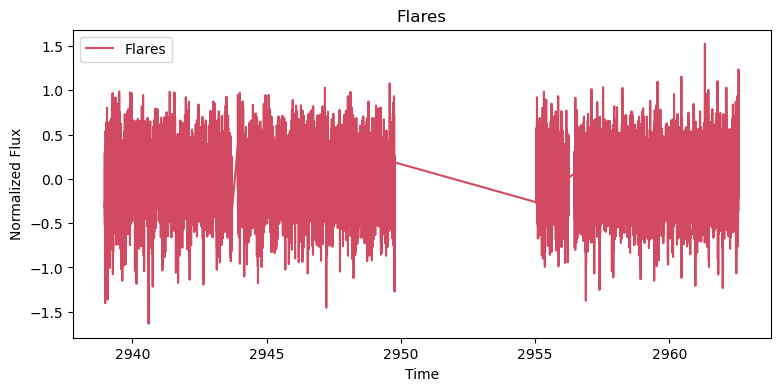

In [19]:
# Get flare data
flare_data = flux - result.best_fit

# Plot the flares
plt.figure(figsize=(9, 4))
plt.plot(time, flare_data, label='Flares', color=palette[2])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Flares')
plt.legend()
plt.show()

#### SDSSJ121258.25-012310.2

In [20]:
# Pull lightcurve data for that star
star_info = porb_df.iloc[17]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                           307
iau_name    SDSSJ121258.25-012310.2
i                           16.6273
porb                       8.060894
porbe                      0.000012
Name: 17, dtype: object 

SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 46 2021      SPOC     120    56813164      0.0
  1 TESS Sector 46 2021 TESS-SPOC     600    56813164      0.0


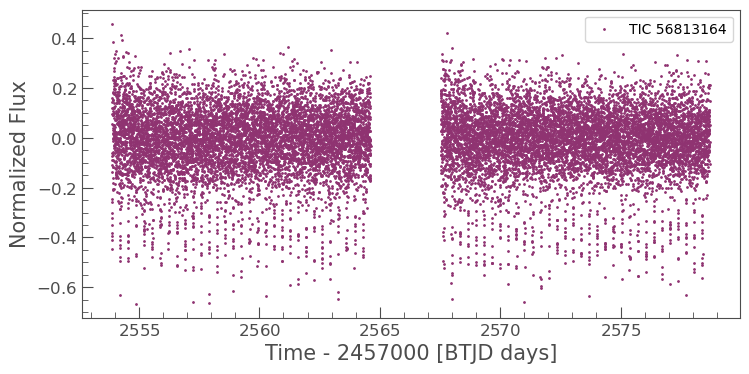

In [21]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[4])
plt.legend()
plt.show()

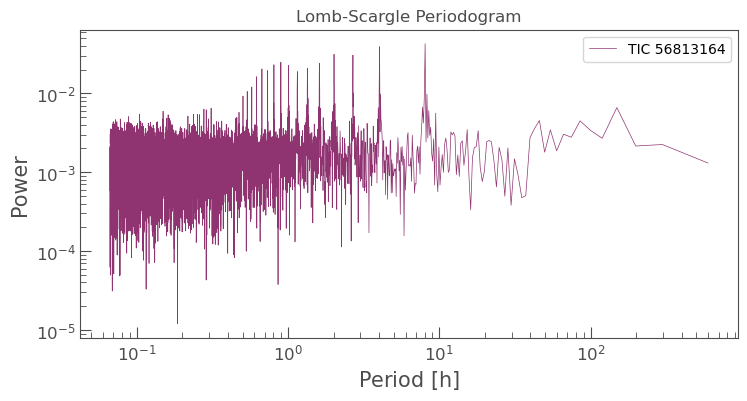

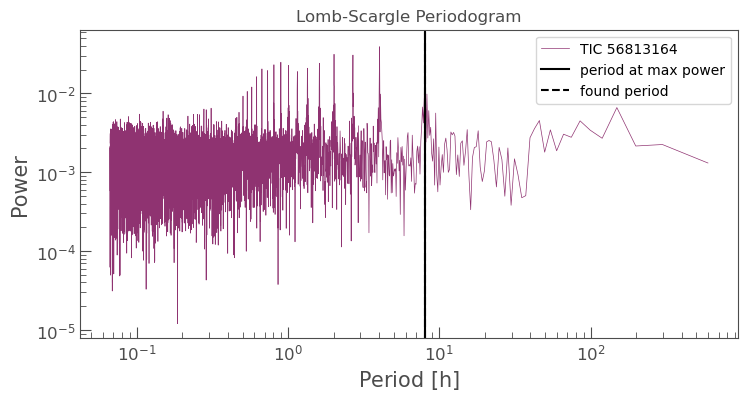

Original calculated period(h): 8.060894 
Period at max power(h): 8.052150340329398


In [22]:
# Make periodogram
found_period = star_info['porb']
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[4], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[4], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.axvline(x = found_period, color= 'black', ls = '--', label = 'found period')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

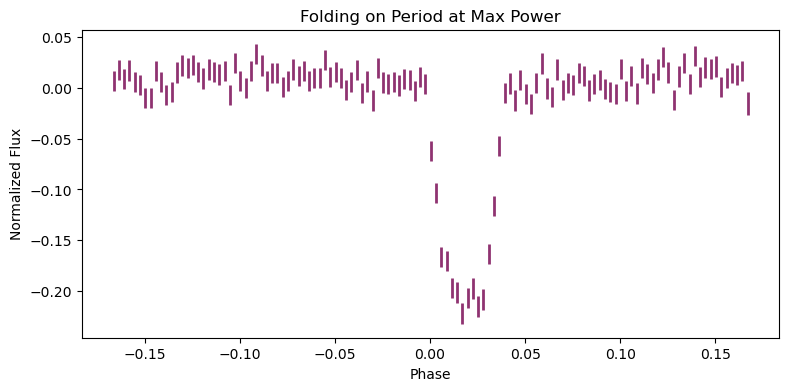

In [23]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(4*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[4], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

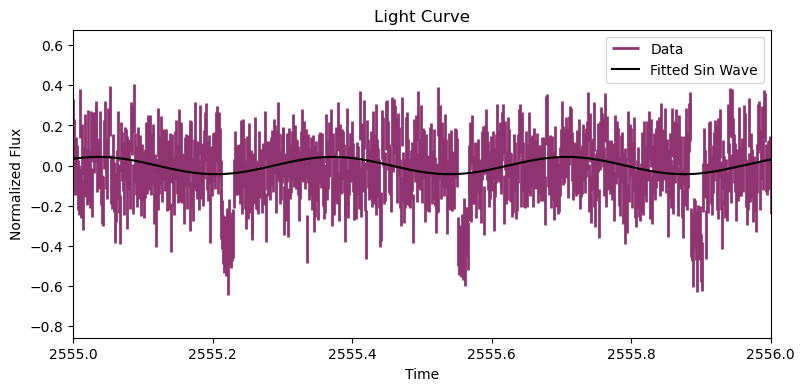

[[Model]]
    Model(sine_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 15759
    # variables        = 3
    chi-square         = 278.206250
    reduced chi-square = 0.01765716
    Akaike info crit   = -63609.9968
    Bayesian info crit = -63587.0013
    R-squared          = 0.03226494
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  0.04308671 (init = 0.04255963)
    frequency:  2.97874839 (init = 2.98057)
    phase:      27.8920734 (init = 0)


In [24]:
# Lightcurve data
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Get the current 'optimal paramteres'
amplitude = max(star_periodogram.power.value)
frequency = 1/star_periodogram.period_at_max_power.value

# Make an lmfit object and fit it
model = lmfit.Model(sine_wave)
params = model.make_params(amplitude=amplitude, frequency=frequency, phase=0.0)
result = model.fit(flux, params, x=time)

# Plot the fitted sin wave
plt.figure(figsize= (9,4))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[4], lw=2, label = 'Data')
plt.plot(time, result.best_fit, color= 'black', label = 'Fitted Sin Wave')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(2555, 2556)
plt.legend()
plt.show()

print(result.fit_report())

In [25]:
best_fit_frequency = result.params['frequency'].value
best_fit_period = 1/best_fit_frequency

print(f"Best fit period: {best_fit_period} days")
print(f"Period at max power: {star_periodogram.period_at_max_power.value} days")
print(f"Period from literature: {found_period/24} days")

Best fit period: 0.3357114694727804 days
Period at max power: 0.3355062641803916 days
Period from literature: 0.3358705833333333 days


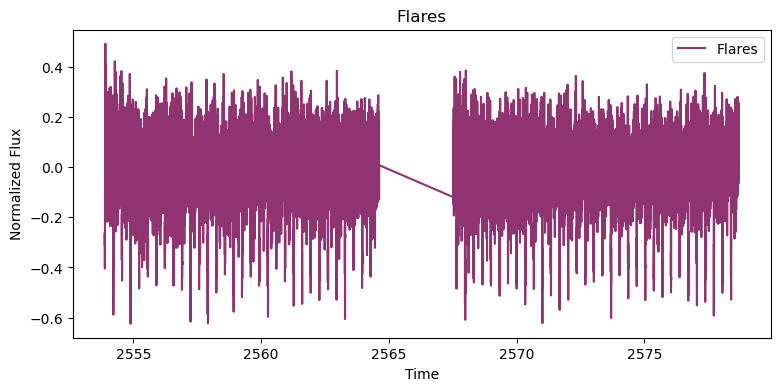

In [26]:
# Get flare data
flare_data = flux - result.best_fit

# Plot the flares
plt.figure(figsize=(9, 4))
plt.plot(time, flare_data, label='Flares', color=palette[4])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Flares')
plt.legend()
plt.show()

### Stars w/o known period

In [27]:
palette = sns.color_palette(palette='crest')
palette

[(0.48942421, 0.72854938, 0.56751036),
 (0.34892097, 0.64828676, 0.56513633),
 (0.24929311, 0.56486397, 0.5586654),
 (0.15615526, 0.47913212, 0.54850526),
 (0.11131735, 0.39155635, 0.53422678),
 (0.14573579, 0.29354139, 0.49847009)]

#### SDSSJ002157.90-110331.6

In [28]:
# Pull lightcurve data for that star
star_info = no_porb_df.iloc[4]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                             4
iau_name    SDSSJ002157.90-110331.6
i                           17.0707
porb                            0.0
porbe                           0.0
Name: 4, dtype: object 

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 70 2023   SPOC     120    37774360      0.0


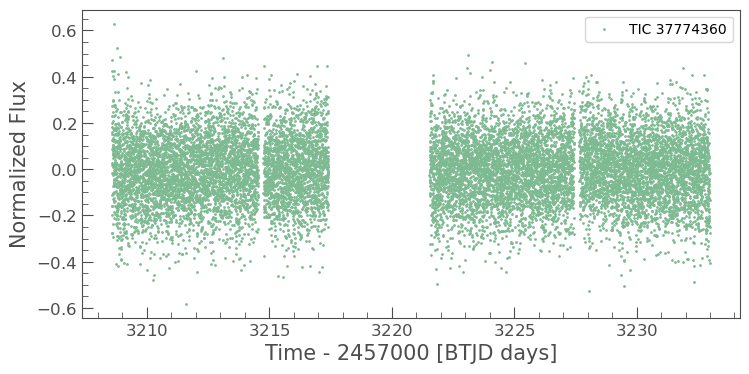

In [29]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[0])
plt.legend()
plt.show()

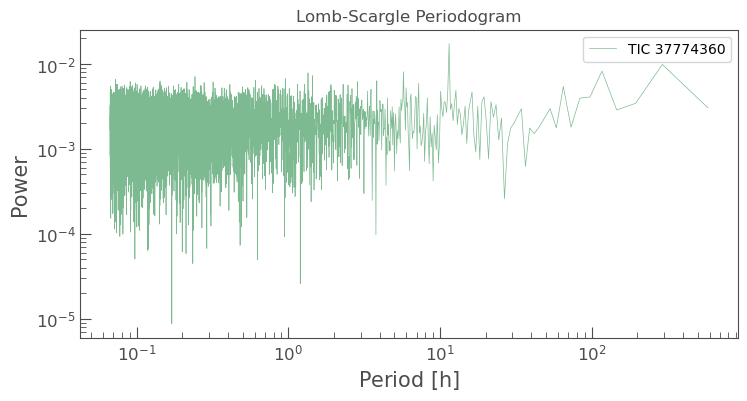

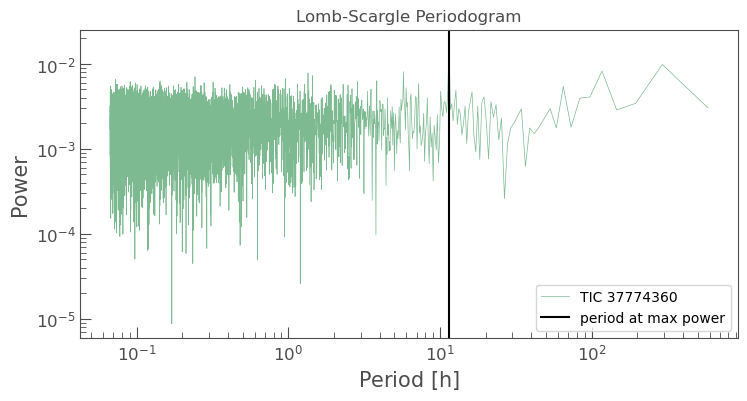

Original calculated period(h): 8.060894 
Period at max power(h): 11.48607821050224


In [30]:
# Make periodogram
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[0], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

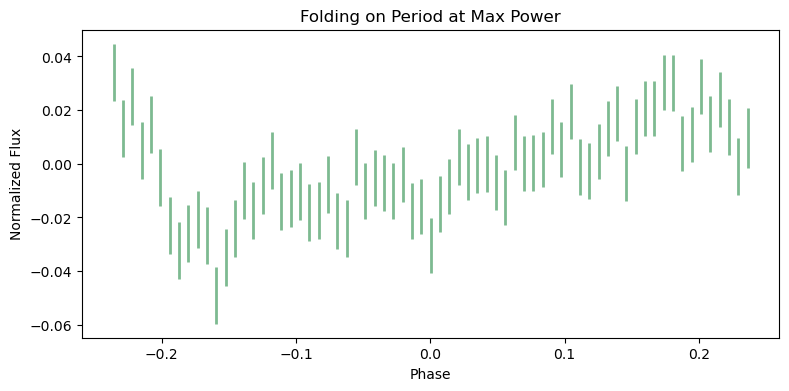

In [31]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(10*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[0], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

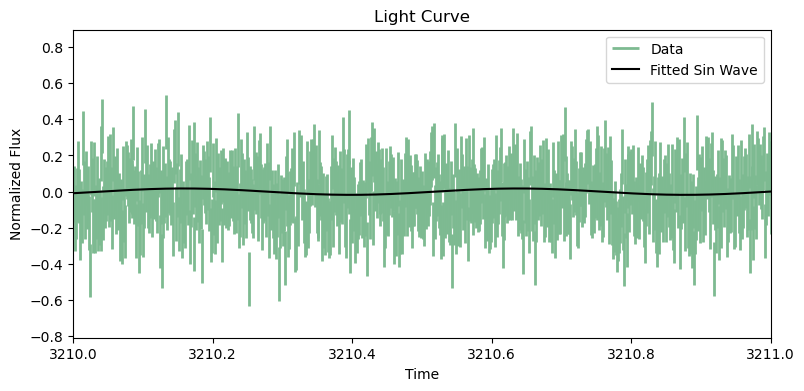

[[Model]]
    Model(sine_wave)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8000
    # data points      = 14297
    # variables        = 3
    chi-square         = 279.578145
    reduced chi-square = 0.01955913
    Akaike info crit   = -56245.8776
    Bayesian info crit = -56223.1742
    R-squared          = 0.00775148
##  Warning: uncertainties could not be estimated:
[[Variables]]
    amplitude:  0.01761705 (init = 0.01727818)
    frequency:  2.08681414 (init = 2.089486)
    phase:      51.8030865 (init = 0)


In [32]:
# Lightcurve data
time = star_lightcurve.time.value
flux = star_lightcurve.flux.value
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Get the current 'optimal paramteres'
amplitude = max(star_periodogram.power.value)
frequency = 1/star_periodogram.period_at_max_power.value

# Make an lmfit object and fit it
model = lmfit.Model(sine_wave) # check me!
params = model.make_params(amplitude=amplitude, frequency=frequency, phase=0.0)
result = model.fit(flux, params, x=time)

# Plot the fitted sin wave
plt.figure(figsize= (9,4))
plt.vlines(time, flux_lower_err, flux_upper_err, color=palette[0], lw=2, label = 'Data')
plt.plot(time, result.best_fit, color= 'black', label = 'Fitted Sin Wave')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Light Curve')
plt.xlim(3210, 3211)
plt.legend()
plt.show()

print(result.fit_report())

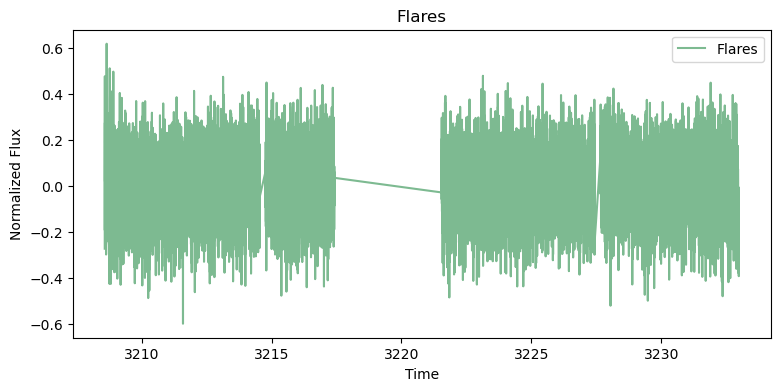

In [33]:
# Get flare data
flare_data = flux - result.best_fit

# Plot the flares
plt.figure(figsize=(9, 4))
plt.plot(time, flare_data, label='Flares', color=palette[0])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')
plt.title('Flares')
plt.legend()
plt.show()

In [34]:
# Pull lightcurve data for that star
star_info = no_porb_df.iloc[6]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                             6
iau_name    SDSSJ002620.41+144409.5
i                           16.6517
porb                            0.0
porbe                           0.0
Name: 6, dtype: object 

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 70 2023   SPOC     120   336693494      0.0


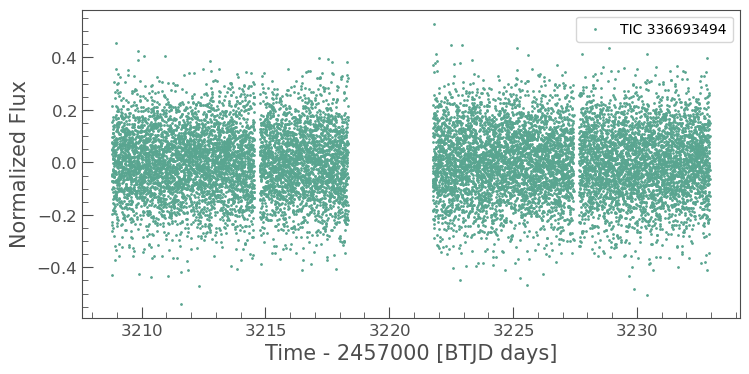

In [35]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[1])
plt.legend()
plt.show()

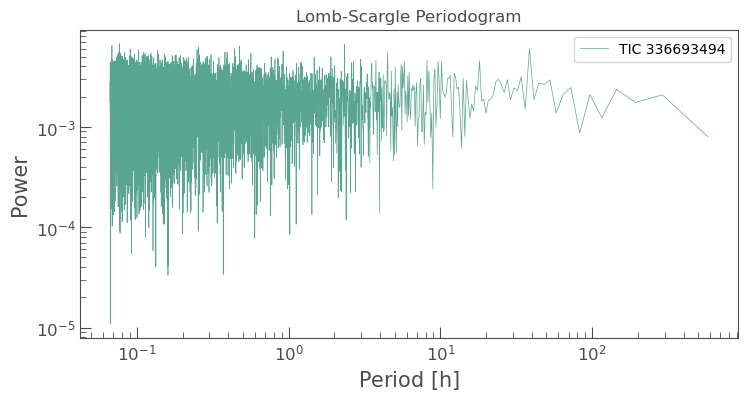

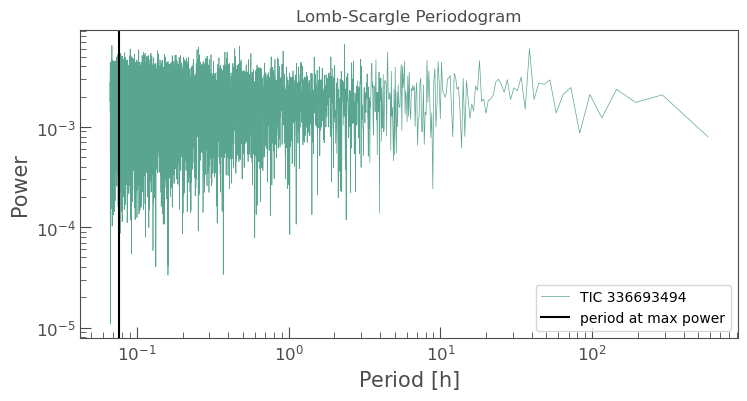

Original calculated period(h): 8.060894 
Period at max power(h): 0.07676527435555569


In [36]:
# Make periodogram
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

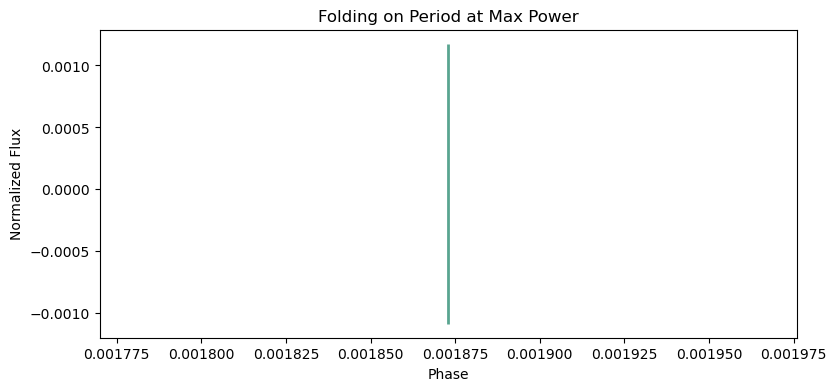

In [37]:
# Defined folded and binned lightcurve
phase_lightcurve = star_lightcurve.fold(period=star_periodogram.period_at_max_power)
binned_lightcurve = phase_lightcurve.bin(10*u.min) 

# Define phase, flux, and lower and upper flux bounds 
phase = binned_lightcurve.phase.value
flux = binned_lightcurve.flux.value
flux_lower_err = binned_lightcurve.flux - binned_lightcurve.flux_err
flux_upper_err = binned_lightcurve.flux + binned_lightcurve.flux_err

# Plot
plt.figure(figsize= (9,4))
plt.vlines(phase, flux_lower_err, flux_upper_err, color=palette[1], lw=2)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.title('Folding on Period at Max Power')
# plt.xlim(-0.5, 0.5)
plt.show()

In [39]:
# Pull lightcurve data for that star
star_info = no_porb_df.iloc[7]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                             7
iau_name    SDSSJ002749.99-001023.3
i                            17.087
porb                            0.0
porbe                           0.0
Name: 7, dtype: object 

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 70 2023   SPOC     120   284078168      0.0


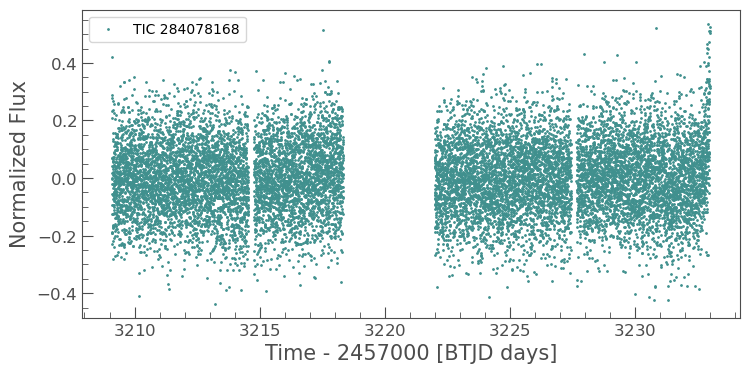

In [40]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[2])
plt.legend()
plt.show()

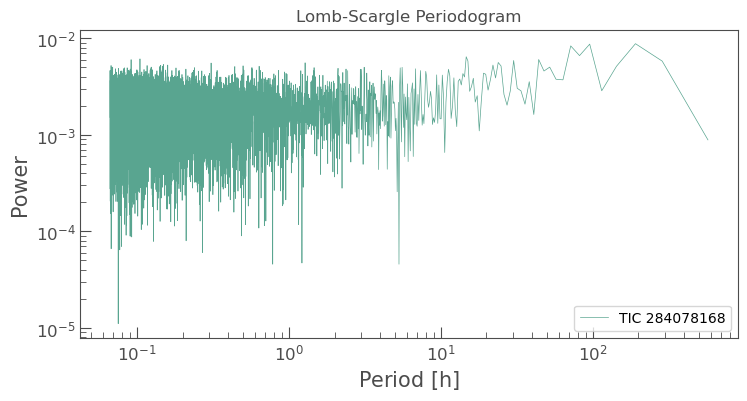

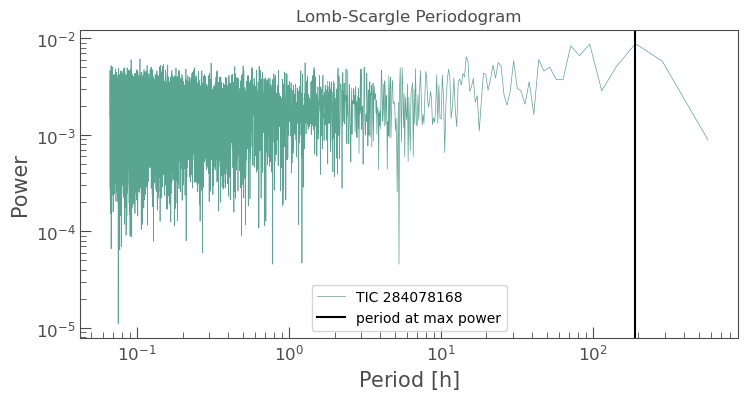

Original calculated period(h): 8.060894 
Period at max power(h): 191.13177077823642


In [41]:
# Make periodogram
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')

In [42]:
# Pull lightcurve data for that star
star_info = no_porb_df.iloc[8]
star_result = lk.search_lightcurve(star_info['iau_name'], mission='TESS')

print(star_info, '\n')
print(star_result)

index                             8
iau_name    SDSSJ002921.27-002032.8
i                           17.6625
porb                            0.0
porbe                           0.0
Name: 8, dtype: object 

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 70 2023   SPOC     120   244177481      0.0


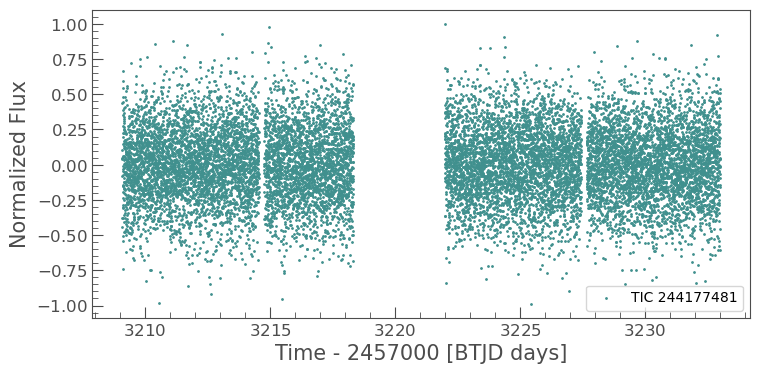

In [43]:
# Download 'best' lightcurve
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1

# Plot
star_lightcurve.scatter(color=palette[2])
plt.legend()
plt.show()

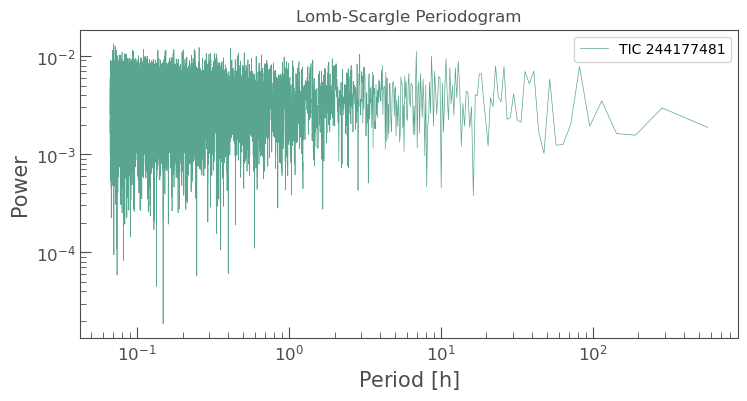

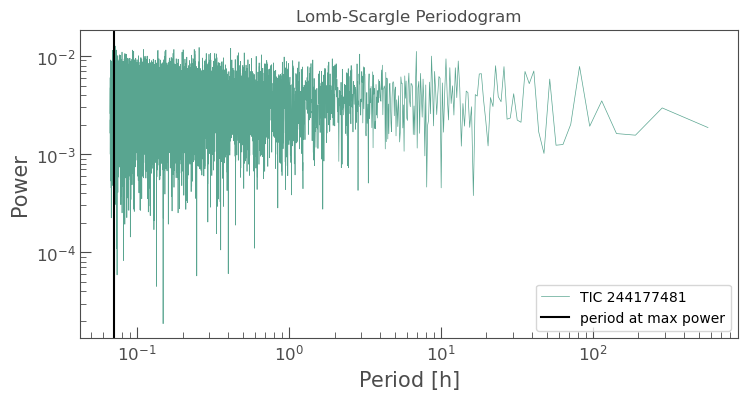

Original calculated period(h): 8.060894 
Period at max power(h): 0.07021847321795922


In [44]:
# Make periodogram
star_periodogram = star_lightcurve.to_periodogram(oversample_factor=1)

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Plot
star_periodogram.plot(color=palette[1], view='period', scale='log', unit=u.hr)
plt.axvline(x = star_periodogram.period_at_max_power.value*24, color='black', label = 'period at max power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.show()

# Print necessary values
print(f'Original calculated period(h): {found_period}', '\n'
      f'Period at max power(h): {star_periodogram.period_at_max_power.value*24}')